In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import json
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [31]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
    return data

data = readData()

In [39]:

def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    truthOnehot = np.zeros((truth.size, 2))
    truthOnehot[np.arange(truth.size), truth] = 1
    misc = np.array(misc)
    return X, T, truthOnehot, misc



X, T, y, misc = convertData(data)

In [48]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = getTrainTestSplit(X, y)


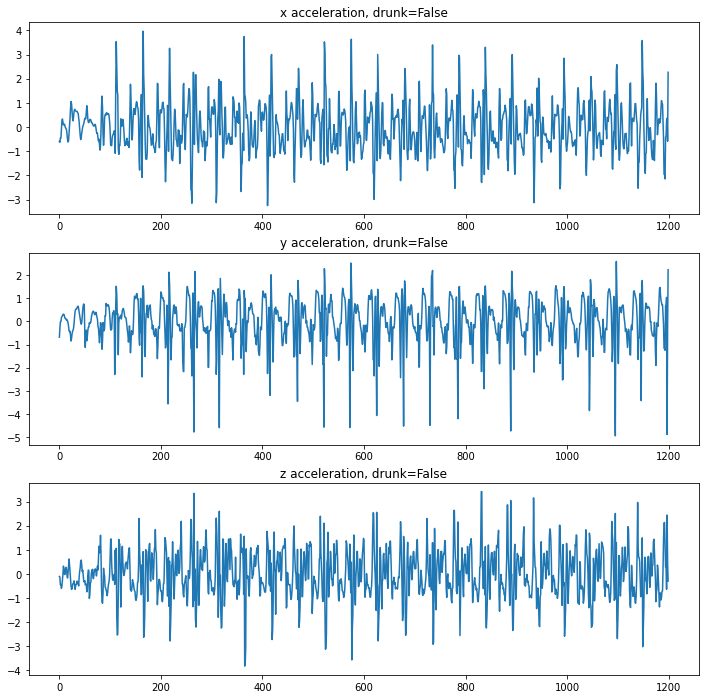

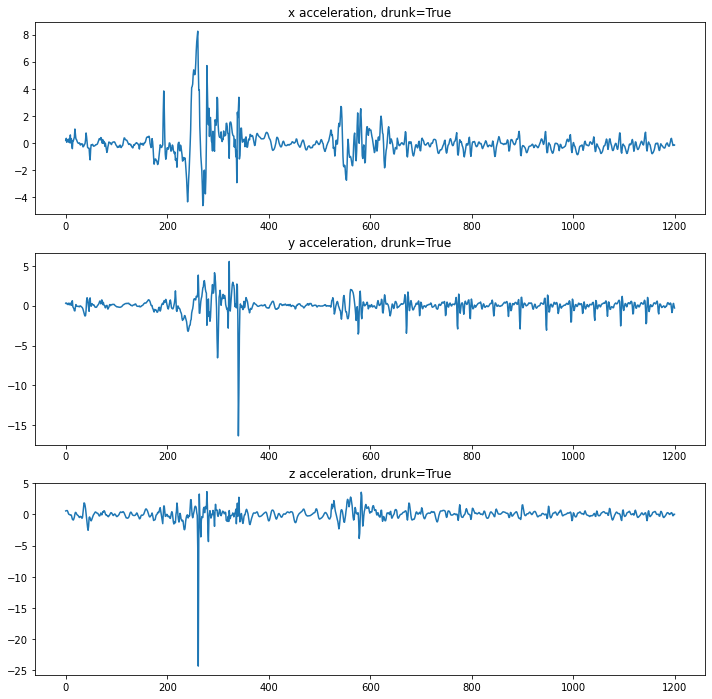

In [49]:
def plot(ax, y, title):
    ax.plot([i for i in range(len(y))], y)
    ax.set_title(title)
    #ax.title = title

def plotdata(X, T, y):
    for option in range(y.shape[1]):
        series = random.choice(X[y.T[option]==1])
        fig, axes = plt.subplots(nrows=3, figsize=(12,12))
        for ax, vals, label in zip(axes, series.T, "xyz"):
            plot(ax, vals, f"{label} acceleration, drunk={option==1}")

plotdata(X, T, y)



In [50]:
def trainModel(X, y):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=6, batch_size=32)

    return model

model = trainModel(X_train, y_train)
model.evaluate(X_test, y_test, batch_size=32, verbose=0)

Epoch 1/6


ValueError: in user code:

    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 1) are incompatible


In [36]:
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(X_train, y_train, X_test, y_test, repeats=10):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		model = trainModel(X_train, y_train)
		_, score = model.evaluate(X_test, y_test)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

# run the experiment
run_experiment(X_train, y_train, X_test, y_test)

Epoch 1/6
6/6 [==============================] - 1s 116ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 2/6
6/6 [==============================] - 1s 141ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 3/6
6/6 [==============================] - 1s 137ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 4/6
6/6 [==============================] - 1s 126ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 5/6
6/6 [==============================] - 1s 119ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 6/6
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.2391
>#1: 23.913
Epoch 1/6
6/6 [==============================] - 1s 115ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 2/6
6/6 [==============================] - 1s 116ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 3/6
6/6 [==============================] - 1s 116ms/step - loss: 0.0000e+00 - accuracy: 0.1585
Epoch 4/6
6/6 [==============================] - 1s 128ms/step - loss: 0.0000e+0